In [1]:
%load_ext autoreload
%autoreload 2

# Getting Started

## 1. Import

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
import seaborn as sns
sns.set()

from rul_pm.dataset.lives_dataset import AbstractLivesDataset
from rul_pm.dataset.CMAPSS import (process_file_train, 
                                   process_file_test, engines, sensor_indices,
                                   operation_mode)
from rul_pm.iterators.iterators import LifeDatasetIterator
from rul_pm.iterators.utils import  true_values
from rul_pm.transformation.transformers import Transformer
from rul_pm.transformation.features.selection import (
    ByNameFeatureSelector,
    PandasVarianceThreshold,
    PandasNullProportionSelector)
from rul_pm.transformation.utils import PandasTransformerWrapper
from rul_pm.transformation.features.outliers import IQROutlierRemover, ZScoreOutlierRemover
from rul_pm.transformation.features.imputers import ForwardFillImputer, PandasMeanImputer
from rul_pm.transformation.features.scalers import PandasMinMaxScaler
from rul_pm.transformation.pipeline import LivesPipeline
from rul_pm.transformation.features.extraction import RollingStatisticsPandas
from rul_pm.transformation.transformerstep import Concatenate
from rul_pm.transformation.target import PicewiseRUL

from rul_pm.transformation.features.resamplers import ResamplerTransformer
from rul_pm.iterators.iterators import WindowedDatasetIterator, LifeDatasetIterator
from rul_pm.iterators.batcher import Batcher
from rul_pm.models.keras.models.simple import FCN
from rul_pm.models.keras.models.XiangQiangJianQiao import XiangQiangJianQiaoModel




from rul_pm.transformation.utils import PandasTransformerWrapper
from rul_pm.transformation.features.imputers import ForwardFillImputer, PandasRemoveInf, PerColumnImputer
from rul_pm.transformation.utils import IdentityTransformer
from rul_pm.graphics.duration import (durations_boxplot, 
                                      add_vertical_line,
                                      lives_duration_histogram, 
                                      lives_duration_histogram_from_durations)
from rul_pm.graphics.plots import plot_true_and_predicted, plot_life
from rul_pm.results.results import split_lives
from rul_pm.graphics.embedding import tsne

## 2. Dataset

The Dataset comes in a space separated tabular file. The functions `process_file_train` and `process_file_test` receive the filename of the dataset file and return a `pd.DataFrame` with the pre-processed data. The `UnitNumber` column is a life identifier.

In order to define a dataset you should subclass `AbstractLivesDataset` and define three methods:

  * `__getitem__(self, i)`: This method should return the i-th life 
  * `nlives(self)`: In this method should return the total number of lives present in the dataset

In [3]:
class CMAPSSDataset(AbstractLivesDataset):
    def __init__(self, train=True, model=None):
        if model is not None:
            if model not in operation_mode:
                raise ValueError(
                    f'Invalid model: valid model are {list(operation_mode.keys())}')
        if train:
            processing_fun = process_file_train
        else:
            processing_fun = process_file_test
        self.lives = []
        for engine in engines:
            if model is not None and engine != model:
                continue
            for _, g in processing_fun(engine).groupby('UnitNumber'):
                g.drop(columns=['UnitNumber'], inplace=True)
                self.lives.append(g)
                
    @property
    def rul_column(self) -> str:
        return 'RUL'
    
    def __getitem__(self, i):
        return self.lives[i]

    @property
    def nlives(self):
        return len(self.lives)

In [4]:
train_dataset = CMAPSSDataset(train=True, model='FD001')
validation_dataset = CMAPSSDataset(train=False, model='FD001')

### 1.1 Number of lives in the training set

In [5]:
len(train_dataset)

100

### 1.2 Number of lives in the validation set

In [6]:
len(validation_dataset)

100

## 2. Visualization

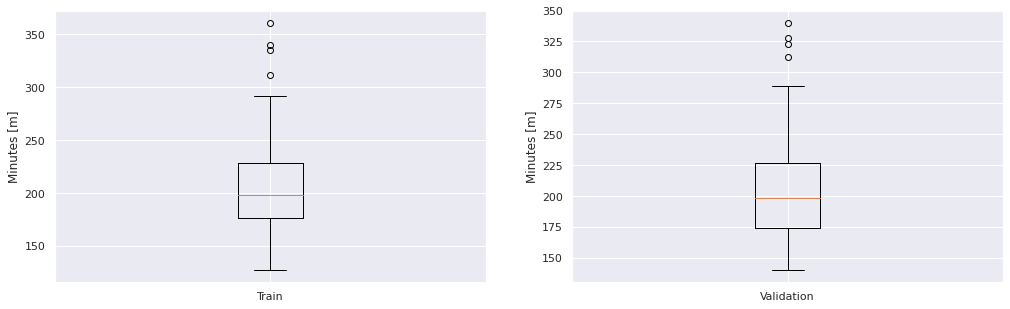

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
durations_boxplot(train_dataset, xlabel='Train', ylabel='Minutes [m]', ax=ax[0])
durations_boxplot(validation_dataset, xlabel='Validation', ylabel='Minutes [m]', ax=ax[1]);

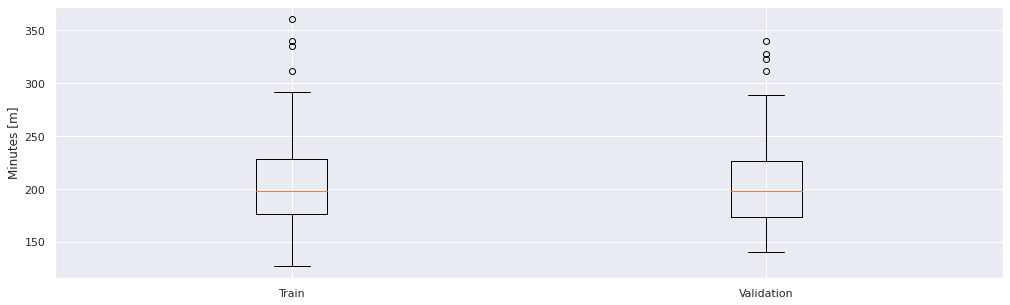

In [8]:
fig, ax = durations_boxplot([train_dataset, validation_dataset], 
                  xlabel=['Train', 'Validation'], 
                  ylabel='Minutes [m]',
                  figsize=(17, 5))

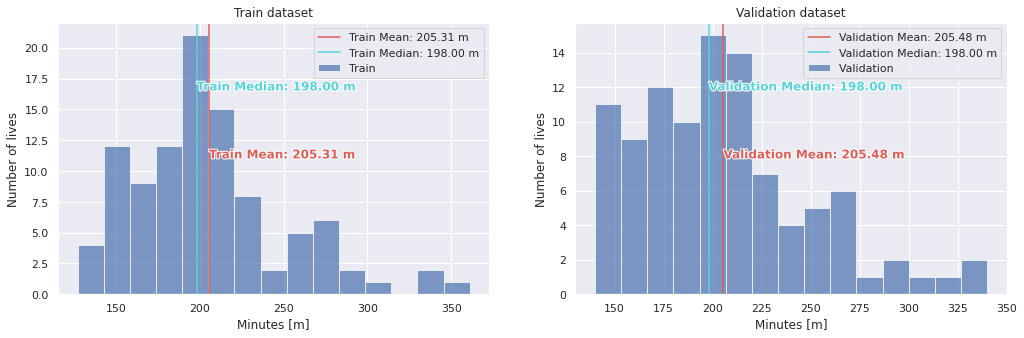

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
lives_duration_histogram(train_dataset, 
                         label='Train',
                         xlabel='Minutes [m]', 
                         alpha=0.7,
                         ax=ax[0])
ax[0].set_title('Train dataset')
lives_duration_histogram(validation_dataset, 
                         label='Validation',
                         xlabel='Minutes [m]', 
                         alpha=0.7,
                         ax=ax[1])
ax[1].set_title('Validation dataset');

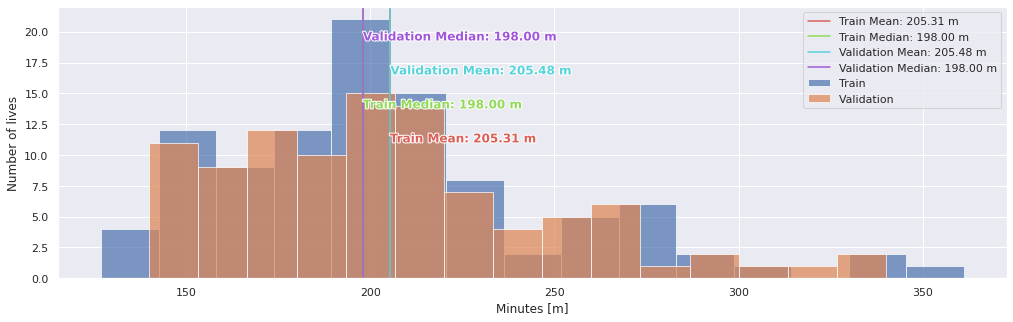

In [10]:
lives_duration_histogram([train_dataset,validation_dataset], 
                         label=['Train','Validation'],
                         xlabel='Minutes [m]', 
                         alpha=0.7,
                         figsize=(17, 5));

## 3. Transformers

There are two ways of defining a transformer. The first way is more similar to the scikit-learn Pipeline API, and the other one is similar to the tensorflow functional API.
Two pipelines have to be defined:
* How the data is going to be transformed
    * This transformer invovles selecting and transforming and generating features
* How the target is going to be transformed
    * This transformer involves selecting and transforming the target

The base class of the pipeline is the `LivesPipeline` class. This class is an extension of `sklearn.pipeline.Pipeline` and change the way the data is fitted. 
Each transformer class inherit from the `TransformerStep`. This class implements the method `partial_fit` which receives the data belonging to the whole life and update its internal state accordingly.

### 3.1 Functional API

Following the literature, the future that addresses this dataset, only a subset of the feature are going to be used to fit our model.

In [11]:
features = [train_dataset[0].columns[i-1] for i in sensor_indices]
features

['OpSet1',
 'OpSet2',
 'OpSet3',
 'SensorMeasure3',
 'SensorMeasure4',
 'SensorMeasure5',
 'SensorMeasure7',
 'SensorMeasure8',
 'SensorMeasure9',
 'SensorMeasure10',
 'SensorMeasure11',
 'SensorMeasure13',
 'SensorMeasure16',
 'SensorMeasure17']

The transformation of the input data will be simple, a feature scaling between -1 and 1 and imputing any missing value or non finite.

In [12]:
functional_pipe = ByNameFeatureSelector(features)
functional_pipe = PandasMinMaxScaler((-1,1), robust=False)(functional_pipe)
functional_pipe = PandasMeanImputer()(functional_pipe)



One common approach for handling PM problems is to downplay the early stages of the execution due to the fact that that is harder to detect indication of degradation at the beggining.

For this dataset, a piece-wise linear degradation model has been validated to be suitable and effective. In general, the engine unit works normally in the early age and degrades linearly afterwards. It is assumed to have a constant RUL label in the initial period.  [1]

[1] Li, X., Ding, Q., & Sun, J. Q. (2018). Remaining useful life estimation in prognostics using deep convolution neural networks. Reliability Engineering & System Safety, 172, 1-11.

In [13]:
target_pipe = ByNameFeatureSelector(['RUL'])
target_pipe = PicewiseRUL(125)(target_pipe)

In [14]:
functional_transformer = Transformer(
    transformerX=functional_pipe.build(),
    transformerY=target_pipe.build())


### 3.2 Scikit-learn API

In [15]:
sklearn_pipe = Transformer(
    transformerX=LivesPipeline(
        steps=[
            ('selection', ByNameFeatureSelector(features)),
            ('scaler', PandasMinMaxScaler((-1,1), robust=True)),
            ('imputer', PandasMeanImputer())
        ]
    ),
    transformerY=LivesPipeline(
        steps=[
            ('select_RUL', ByNameFeatureSelector(['RUL']))
        ]
    )
    
)

sklearn_pipe.fit(train_dataset)


### 3.3 Fitting the transformer

The transformer must be fitted on the dataset.

In [16]:
functional_transformer.fit(train_dataset)

### 3.4 Transforming a life

In [17]:
X, y, m = functional_transformer.transform(train_dataset[0])

In [18]:
X.shape

(192, 14)

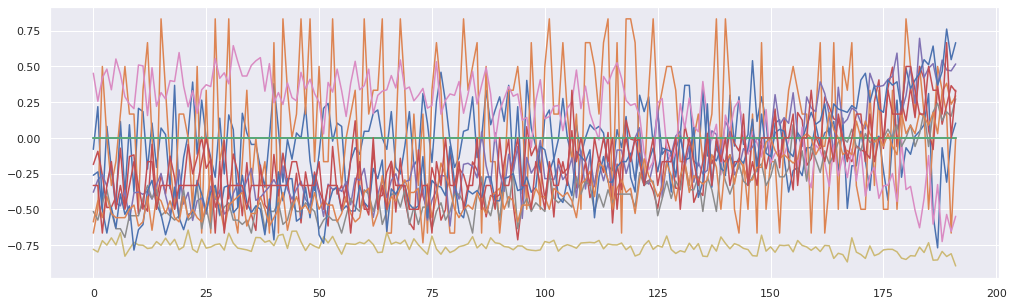

In [19]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(X);

### 3.5 More complex transformers
More complex transformers can also be constructed. For example, we may want to use the raw features but also extract some statistics from a subset of features. In this case, we are going to obtain the kurtosis and the peak coefficient using a rolling window for 3 features. There are a lot of different feature extraction and transformation steps that can be applied. I encourage you to check the documentation to discover more.

The number of features we are going to obtain at the end will be the 14 coming from the raw features and 6=2*3 coming for the two statistics computed from the selected subset of size 3.

In [20]:
raw_pipe = ByNameFeatureSelector(features)
raw_pipe = ForwardFillImputer()(functional_pipe)
raw_pipe = PandasMinMaxScaler((-1,1), robust=False, name='raw_scaled')(functional_pipe)

transformed_pipe = ByNameFeatureSelector(features[0:3])
transformed_pipe = RollingStatisticsPandas(window=15, to_compute=['kurtosis', 'peak'])(transformed_pipe)
transformed_pipe = PandasMeanImputer()(transformed_pipe)
transformed_pipe = PandasMinMaxScaler((-1,1), robust=False, name='transformed_scaled')(transformed_pipe)


pipe = Concatenate()([raw_pipe, transformed_pipe])

target_pipe = ByNameFeatureSelector(['RUL'])

complex_transformer = Transformer(
    transformerX=pipe.build(),
    transformerY=target_pipe.build())

complex_transformer.fit(train_dataset)

In [21]:
X, y, m = complex_transformer.transform(train_dataset[0])

The number of features as expected is 20 features: 14 from the raw features and 6 from the extracted ones

In [22]:
X.shape

(192, 20)

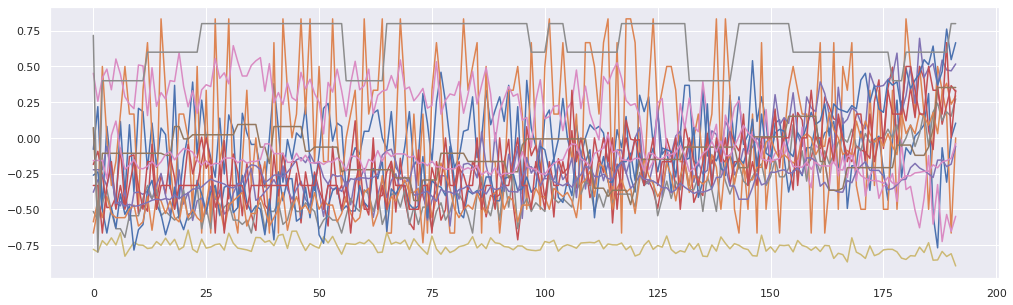

In [23]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(X);

The name of the obtained features are computed from the step names and the selected features

In [24]:
complex_transformer.columns()

array(['raw_scaled_0_OpSet1', 'raw_scaled_0_OpSet2',
       'raw_scaled_0_OpSet3', 'raw_scaled_0_SensorMeasure3',
       'raw_scaled_0_SensorMeasure4', 'raw_scaled_0_SensorMeasure5',
       'raw_scaled_0_SensorMeasure7', 'raw_scaled_0_SensorMeasure8',
       'raw_scaled_0_SensorMeasure9', 'raw_scaled_0_SensorMeasure10',
       'raw_scaled_0_SensorMeasure11', 'raw_scaled_0_SensorMeasure13',
       'raw_scaled_0_SensorMeasure16', 'raw_scaled_0_SensorMeasure17',
       'transformed_scaled_1_OpSet1_kurtosis',
       'transformed_scaled_1_OpSet1_peak',
       'transformed_scaled_1_OpSet2_kurtosis',
       'transformed_scaled_1_OpSet2_peak',
       'transformed_scaled_1_OpSet3_kurtosis',
       'transformed_scaled_1_OpSet3_peak'], dtype=object)

## 4. Iterators

## 4.1 Life iterator

The dataset can be iterated. Each element of the iteration is life in stored in `pd.DataFrame` which contains all the features

In [25]:
train_dataset[0].columns

Index(['Cycle', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1',
       'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5',
       'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8', 'SensorMeasure9',
       'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12',
       'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15',
       'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18',
       'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21', 'RUL',
       'OpMode'],
      dtype='object')

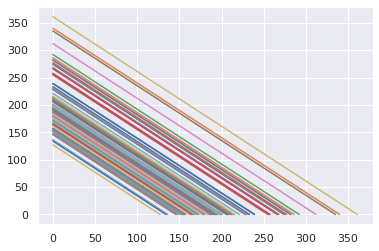

In [26]:
fig, ax = plt.subplots()
for life in train_dataset:
    ax.plot(life['RUL'].values)

## 4.2 WindowedDatasetIterator
The windowed dataset iterator provides a way of iterating the transformed dataset trough an sliding window. The sample for the i-th element, provides the (window-1) elements of the window. It also provides capabilities to shuffle in diverse ways the how the samples are delivered by the iterator.

In [27]:
window = 7
iterator = WindowedDatasetIterator(
    train_dataset,
    window,
    functional_transformer,
    step=1,
    output_size=1,
    shuffle=False)

X, y, sw= next(iterator)

Since we are using the functional_transformer that only has 14 feature and a window size of 7 samples. The output of one element of the iterator wil be a matrix ox size (7 x14)

In [28]:
X.shape

(7, 14)

## 5. Batcher

The batcher class make use of the `WindowedDatasetIterator` to generate batches of samples.

In [29]:
window = 25
batch_size = 66
step = 2
train_batcher = Batcher.new(train_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle=False)
X, y, sw = next(train_batcher)

As expected the shape of the input data of one batch is:
* 66 due to the batch size
* 25 because the lookback window size
* 14 for the selected features in the transformer

In [30]:
X.shape

(66, 25, 14)

In [31]:
y.shape

(66, 1, 1)

### 4.1 How dos a sample looks like?

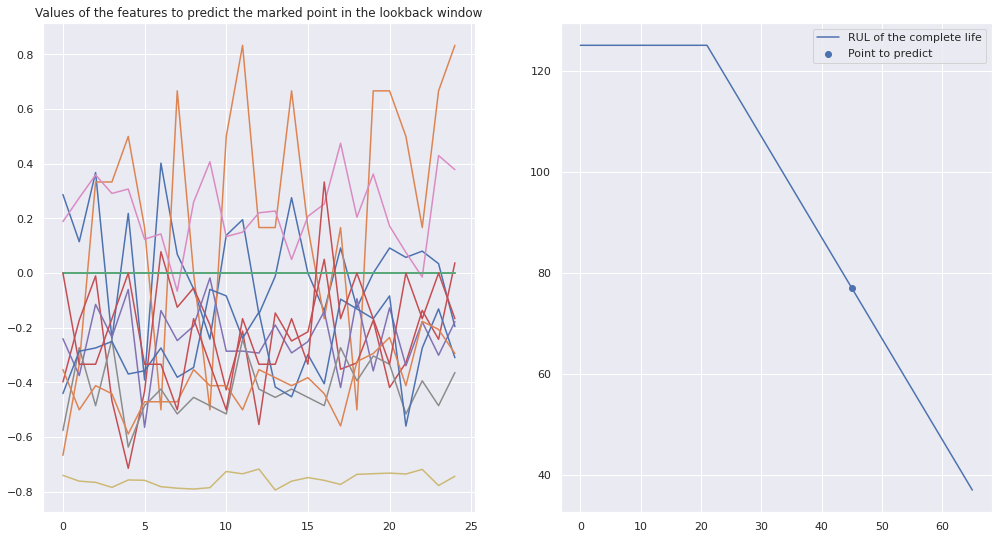

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(17, 9))
for f in range(X.shape[2]):
    ax[0].plot(X[45, :, f])
ax[0].set_title('Values of the features to predict the marked point in the lookback window')
ax[1].plot(np.squeeze(y), label='RUL of the complete life')
ax[1].scatter(x=45, y=y[45], label='Point to predict')
ax[1].legend()

## 5. Model

### 5.1 Fully connected model

Let's create a simple model in keras with some FC layers. 


First of all we need to create two batchers for feeding the model.

In [33]:
step = 1
batch_size = 16
window = 64
train_batcher = Batcher.new(train_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle='all',
                            cache_size=500)
val_batcher = Batcher.new(validation_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle=False,
                            cache_size=500,
                            restart_at_end=False)



In [34]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=5)
model = FCN([512, 256],
            dropout=0.2,
            learning_rate=0.001,
            loss='mse',
            batch_normalization=False,
            l2=None)

r = model.fit(train_batcher, val_batcher , epochs=12, callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 896)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               459264    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 590,849
Trainable params: 590,849
Non-trainable params: 0
__________________________________________________

### 5.1.1 Saving the model

In [43]:
model.save('FC_example')

INFO:tensorflow:Assets written to: /home/luciano/fuentes/lru_gcd/doc/examples/FC_example/assets


#### 5.1.2 Laoading the model

In [47]:
model = FCN.load('FC_example')

#### 5.1.3 Learning curves

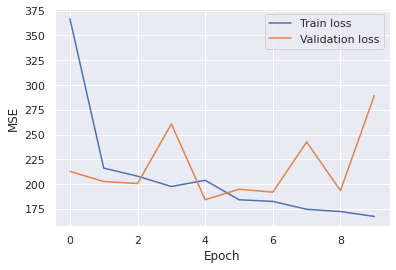

In [48]:
fig, ax = plt.subplots()
ax.plot(r['loss'], label='Train loss')
ax.plot(r['val_loss'], label='Validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.legend()

#### 5.1.4 Prediction on the training set

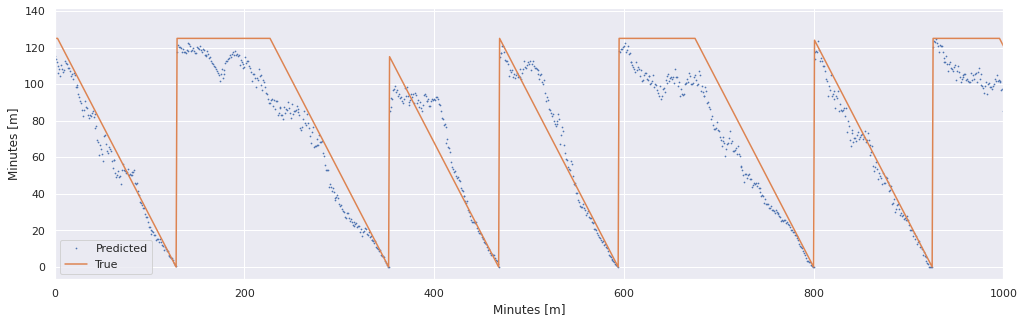

In [49]:
train_batcher = Batcher.new(train_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            1, 
                            cache_size=500,
                            shuffle=False,
                            restart_at_end=False)

y_pred = model.predict(train_batcher)
y_true = true_values(train_batcher.iterator)

ax = plot_true_and_predicted(
    {
        'FCN': [
            {
                'true': y_true,
                'predicted': y_pred
            }
        ]
    },
    units='Minutes [m]',
    figsize=(17, 5))

ax.set_xlim(0, 1000);

#### 5.1.5 Prediction on the validation set

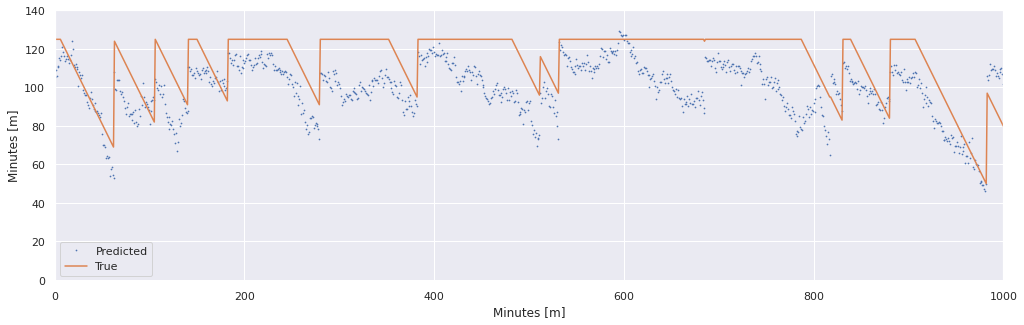

In [50]:

y_pred = model.predict(val_batcher)
y_true = true_values(val_batcher.iterator)
ax = plot_true_and_predicted(
    {
        'FCN': [
            {
                'true': y_true,
                'predicted': y_pred
            }
        ]
    },
    units='Minutes [m]',
    figsize=(17, 5))

ax.set_xlim(0, 1000);

Instead of having an array with all the predictions, another possibility to handling the predictions is using the `FittedLife class`. The function `split_lives` splits the whole set of predictions into a list of `FittedLife` objects.

In [59]:
lives = split_lives(y_true, y_pred, RUL_threshold=125)

In [60]:
lives[0:3]

We can plot one independent life and show also a RLS fitted from the predicted points

<AxesSubplot:xlabel='Unit Cycles', ylabel='Unit Cycles'>

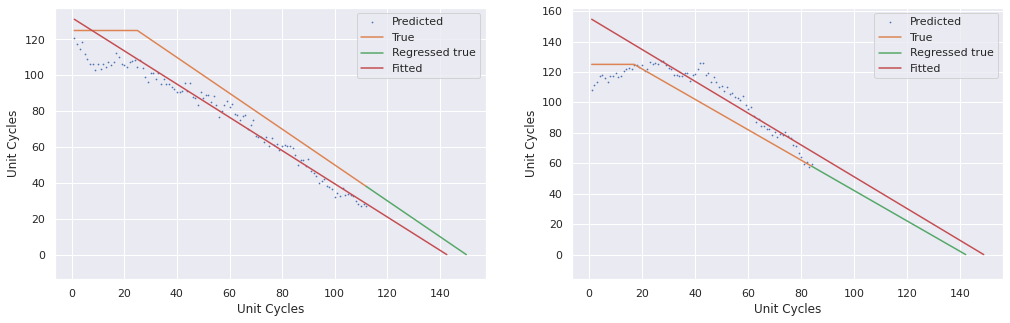

In [75]:
life1 = 45
life2 = 15
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
plot_life(lives[life1], units='Unit Cycles', add_fitted=True, ax=ax[0])
plot_life(lives[life2], units='Unit Cycles', add_fitted=True, ax=ax[1])

From each of the lives we cam compute diverse metrics:
* MAE
* RMSE
* Unexploited lifetime [1]
* Unexpected breaks [1]

[1] Machine Learning for Predictive Maintenance: A Multiple Classifiers Approach
    Susto, G. A., Schirru, A., Pampuri, S., McLoone, S., & Beghi, A. (2015). 

In [74]:

pd.DataFrame({
    'MAE': [lives[life1].mae(), lives[life2].mae()],
    'RMSE': [lives[life1].rmse(), lives[life2].rmse()],
    'Unexpected Break': [lives[life1].unexpected_break(), lives[life2].unexpected_break()],
    'Unexploited lifetime [m]': [lives[life1].unexploited_lifetime(), lives[life2].unexploited_lifetime()]
},
index=['Life 1', 'Life 2'])

,MAE,RMSE,Unexpected Break,Unexploited lifetime [m]
Life 1,13.557699,14.295415,False,7.404411
Life 3,10.621696,12.333680,True,0.000000


## 5.2 A more complex model

We can use the model defined in the article "Remaining useful life estimation in prognostics using deep convolution neural networks" by Xiang Lia, Qian Ding and Jian-Qiao Sun already defined in the library.

In [131]:
from tensorflow.keras.callbacks import LearningRateScheduler

from rul_pm.models.keras.losses import root_mean_squared_error

step = 1
batch_size = 128
window = 30
train_batcher = Batcher.new(train_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle='all',
                            cache_size=500)
val_batcher = Batcher.new(validation_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle=False,
                            cache_size=500,
                            restart_at_end=False)

def scheduler(epoch, lr):
    """Learning rate as reported in the article"""
    if epoch < 200:
        return 0.001
    else:
        return 0.0001


model = XiangQiangJianQiaoModel(n_filters=10,
                                filter_size=10,
                                dropout=0.5,
                                loss=root_mean_squared_error, 
                                learning_rate=0.001)
r = model.fit(train_batcher, val_batcher , epochs=25, callbacks=[LearningRateScheduler(scheduler, verbose=True)])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 14)]          0         
_________________________________________________________________
lambda (Lambda)              (None, 30, 14, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 14, 10)        110       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 14, 10)        1010      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 14, 10)        1010      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 14, 10)        1010      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 14, 1)         31    

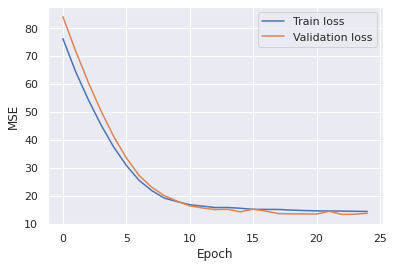

In [132]:
fig, ax = plt.subplots()
ax.plot(r['loss'], label='Train loss')
ax.plot(r['val_loss'], label='Validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.legend()

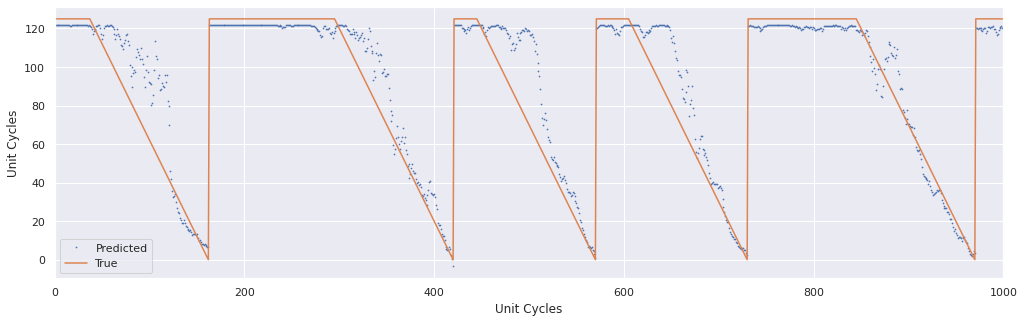

In [133]:
train_batcher = Batcher.new(train_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle=False,
                            cache_size=500)
y_pred = model.predict(train_batcher)
y_true = true_values(train_batcher.iterator)
ax = plot_true_and_predicted(
    {
        'XiangQiangJianQiaoModel': [
            {
                'true': y_true,
                'predicted': y_pred
            }
        ]
    },
    units='Unit Cycles',
    figsize=(17, 5))

ax.set_xlim(0, 1000);

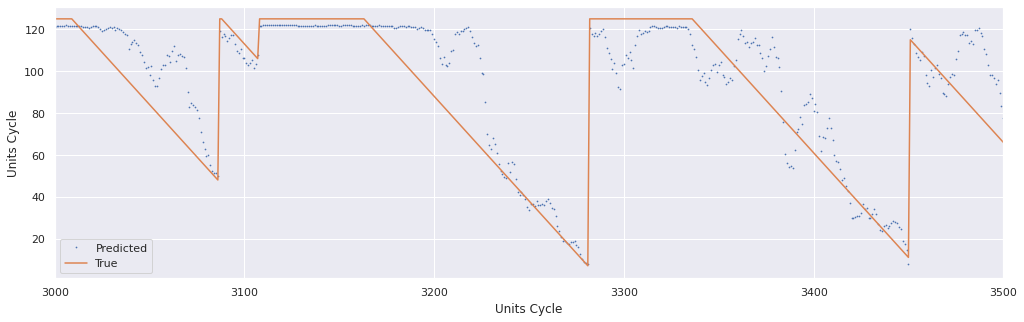

In [137]:

y_pred = model.predict(val_batcher)
y_true = true_values(val_batcher.iterator)
ax = plot_true_and_predicted(
    {
        'XiangQiangJianQiaoModel': [
            {
                'true': y_true,
                'predicted': y_pred
            }
        ]
    },
    units='Units Cycle',
    figsize=(17, 5))

ax.set_xlim(3000, 3500);

In [138]:
lives = split_lives(y_true, y_pred, RUL_threshold=125)

/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1786: RuntimeWarning: divide by zero encountered in log
  (self.k_endog - nmissing - nsingular) * np.log(self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1786: RuntimeWarning: invalid value encountered in multiply
  (self.k_endog - nmissing - nsingular) * np.log(self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1787: RuntimeWarning: invalid value encountered in true_divide
  + scale_obs / self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1807: RuntimeWarning: divide by zero encountered in true_divide
  self.tmp2 = self.tmp2 / self.scale
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1807: RuntimeWarning: invalid value encountered in true_divi

<AxesSubplot:xlabel='Units Cycle [m]', ylabel='Units Cycle [m]'>

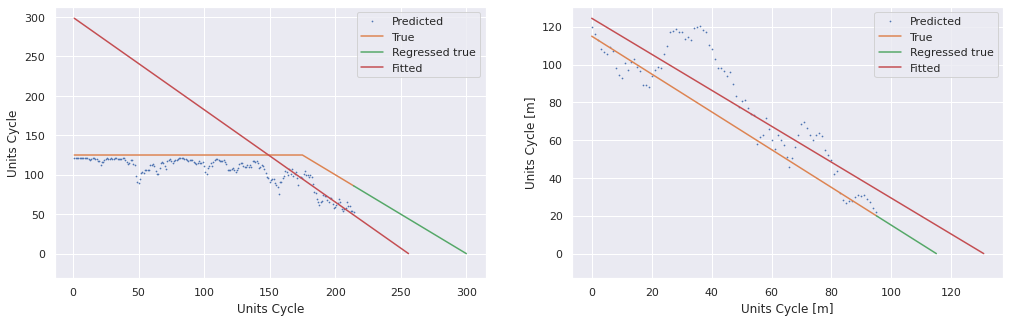

In [146]:
life1 = 82
life2 = 33
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
plot_life(lives[life1], units='Units Cycle', add_fitted=True, ax=ax[0])
plot_life(lives[life2], units='Units Cycle', add_fitted=True, ax=ax[1])

In [148]:

pd.DataFrame({
    'MAE': [lives[life1].mae(), lives[life2].mae()],
    'RMSE': [lives[life1].rmse(), lives[life2].rmse()],
    'Unexpected Break': [lives[life1].unexpected_break(), lives[life2].unexpected_break()],
    'Unexploited lifetime': [lives[life1].unexploited_lifetime(), lives[life2].unexploited_lifetime()]
},
index=['Life 1', 'Life 2'])

,MAE,RMSE,Unexpected Break,Unexploited lifetime
Life 1,17.242183,21.084325,False,44.092412
Life 2,13.810135,18.152979,True,0.000000


## 5.3 A custom model
Also the library allows the creation of custom Keras and Pytorch models. 


In [157]:
from rul_pm.models.keras.keras import KerasTrainableModel
from tensorflow.keras import Model
from tensorflow.keras.layers import (Input, Conv1D, Flatten, Dense)


class CustomModel(KerasTrainableModel):
    def build_model(self, input_shape):
        x = Input(input_shape)
        input = x
        x = Conv1D(10, 15, activation='relu')(x)
        x = Flatten()(x)
        x = Dense(1, activation='relu')(x)
        return Model(inputs=[input], outputs=[x])
    

In [158]:


from rul_pm.models.keras.losses import root_mean_squared_error

step = 1
batch_size = 128
window = 30
train_batcher = Batcher.new(train_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle='all',
                            cache_size=500)
val_batcher = Batcher.new(validation_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle=False,
                            cache_size=500,
                            restart_at_end=False)




model = CustomModel(loss=root_mean_squared_error, 
                     learning_rate=0.001)
r = model.fit(train_batcher, val_batcher , epochs=25)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 14)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 16, 10)            2110      
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 2,271
Trainable params: 2,271
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
139/139 [==============================] - 3s 14ms/step - loss: 74.0906 - root_mean_squared_error: 64.9021 - val_loss: 25.6420 - val_root_mean_squared_error: 22.9561
Epoch 2/25
139/139 [==============================] - 1s 7ms/step - loss: 25.883

/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1786: RuntimeWarning: divide by zero encountered in log
  (self.k_endog - nmissing - nsingular) * np.log(self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1786: RuntimeWarning: invalid value encountered in multiply
  (self.k_endog - nmissing - nsingular) * np.log(self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1787: RuntimeWarning: invalid value encountered in true_divide
  + scale_obs / self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1807: RuntimeWarning: divide by zero encountered in true_divide
  self.tmp2 = self.tmp2 / self.scale
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1807: RuntimeWarning: invalid value encountered in true_divi

,MAE,RMSE,Unexpected Break,Unexploited lifetime
Life 1,30.563951,32.334850,False,27.785811
Life 2,14.923729,16.727072,True,0.000000


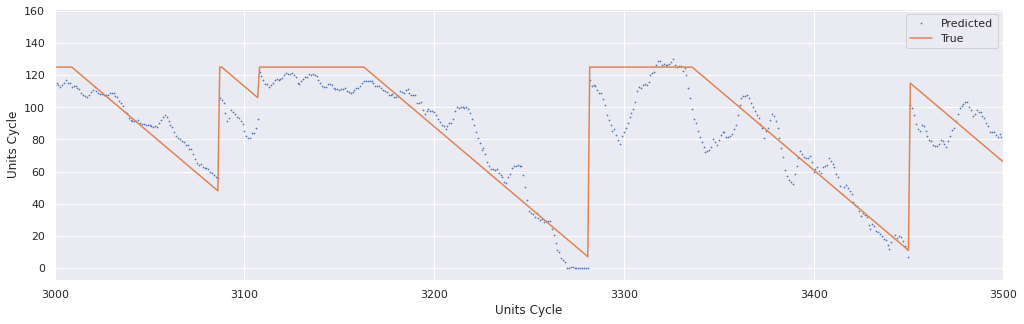

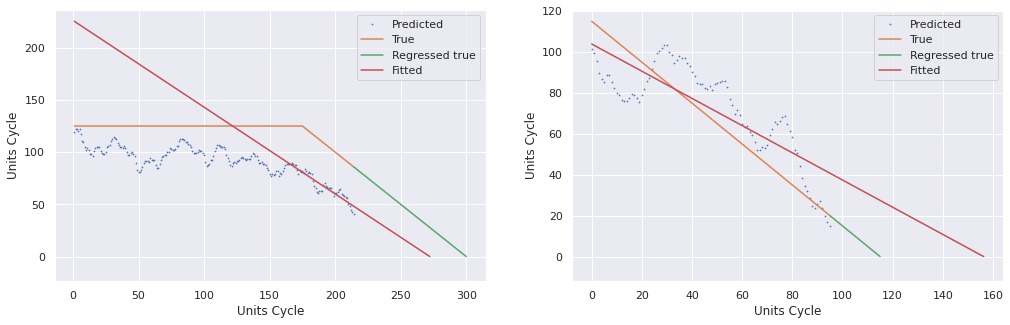

In [160]:

y_pred = model.predict(val_batcher)
y_true = true_values(val_batcher.iterator)
ax = plot_true_and_predicted(
    {
        'CustomModel': [
            {
                'true': y_true,
                'predicted': y_pred
            }
        ]
    },
    units='Units Cycle',
    figsize=(17, 5))

ax.set_xlim(3000, 3500);
lives = split_lives(y_true, y_pred, RUL_threshold=125)
life1 = 82
life2 = 33
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
plot_life(lives[life1], units='Units Cycle', add_fitted=True, ax=ax[0])
plot_life(lives[life2], units='Units Cycle', add_fitted=True, ax=ax[1])


pd.DataFrame({
    'MAE': [lives[life1].mae(), lives[life2].mae()],
    'RMSE': [lives[life1].rmse(), lives[life2].rmse()],
    'Unexpected Break': [lives[life1].unexpected_break(), lives[life2].unexpected_break()],
    'Unexploited lifetime': [lives[life1].unexploited_lifetime(), lives[life2].unexploited_lifetime()]
},
index=['Life 1', 'Life 2'])

### Scikit-learn and gradient boosting models
Following the same meachnism we can create scikit-learn and XGBoost models for regressing our data.

In [ ]:


from rul_pm.models.keras.losses import root_mean_squared_error

step = 1
batch_size = 128
window = 30
train_batcher = Batcher.new(train_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle='all',
                            cache_size=500)
val_batcher = Batcher.new(validation_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle=False,
                            cache_size=500,
                            restart_at_end=False)




model = CustomModel(loss=root_mean_squared_error, 
                     learning_rate=0.001)
r = model.fit(train_batcher, val_batcher , epochs=25)

## Model comparison and evaluation

One of the most important issues regarding PM is the ability to compare and evaluate different methods 